In [47]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [48]:
#importing dataset
data_trains = np.loadtxt('dataset03_modified_setup.txt', delimiter=',')
data_trains[:,0] = [i - 111389 for i in data_trains[:,0]]
data_trains[:,3] = [i - 10 for i in data_trains[:,3]]
print(data_trains)
print(data_trains.shape)

[[ 0.0000000e+00 -7.0000000e-02  9.0000000e-02  6.9000000e-01]
 [ 1.3000000e+01  0.0000000e+00  4.0000000e-02  7.2000000e-01]
 [ 2.6000000e+01 -2.0000000e-02  4.0000000e-02  6.9000000e-01]
 ...
 [ 5.9873606e+07 -8.0000000e-02  1.0000000e-01  6.3000000e-01]
 [ 5.9873619e+07 -9.0000000e-02  8.0000000e-02  8.1000000e-01]
 [ 5.9873632e+07 -1.1000000e-01  5.0000000e-02  7.4000000e-01]]
(4605665, 4)


In [49]:
data_noise = np.loadtxt("stepper_motor/stepper_motor.txt", delimiter=',')
data_noise[:,0] = [i - 26330 for i in data_noise[:,0]]
data_noise[:,3] = [i - 10 for i in data_noise[:,3]]
print(data_noise)

[[ 0.000000e+00 -4.000000e-02  3.000000e-02  7.200000e-01]
 [ 1.300000e+01 -3.000000e-02  7.000000e-02  6.800000e-01]
 [ 2.600000e+01 -3.000000e-02  2.000000e-02  6.800000e-01]
 ...
 [ 8.254621e+06 -2.000000e-02  7.000000e-02  6.700000e-01]
 [ 8.254634e+06 -1.000000e-02  4.000000e-02  7.100000e-01]
 [ 8.254647e+06 -0.000000e+00  4.000000e-02  7.400000e-01]]


In [50]:
# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(data_trains[6000:9000,1:], '-')
# plt.title("Train")
# plt.xlabel("10 msec")
# plt.show()

# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(data_noise[9250:9700,1:], '-')
# plt.title("Noise")
# plt.xlabel("10 msec")
# plt.show()

In [51]:
def combine(x, y, z):
    num_elements = len(x)
    vibrations = []
    
    for i in range(len(x)):
        vibrations.append( math.sqrt(x[i]**2 + y[i]**2 + z[i]**2) )

    return np.array(vibrations)

In [52]:
train_vibrations = combine(data_trains[:,1], data_trains[:,2], data_trains[:,3])
noise_vibrations = combine(data_noise[:,1], data_noise[:,2], data_noise[:,3])

In [53]:
def discrete_window_start_end(a, step, threshold):
    num_elements = len(a)
    events = []
    starts = []
    
    for i in range(0, num_elements, step):
        if( np.var(a[i:i+step]) > threshold ):
            events.append(a[i:i+step])
            starts.append(i)

    return (events, starts)

In [54]:
# step=80
# threshold_factor=30
# threshold = np.var(train_vibrations) * threshold_factor

# trains, starts_trains = discrete_window_start_end(train_vibrations, step, threshold)
# noise, starts_noise = discrete_window_start_end(noise_vibrations, step, threshold)


# print("Number of train events: ", len(starts_trains))
# print("Number of noise events: ", len(starts_noise))
# print("Event threshold: ",threshold)

In [55]:
# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(train_vibrations, '-')

# for i in range(len(trains)):
#     plt.axvspan(starts_trains[i], starts_trains[i]+128, color='yellow', alpha=0.3, label='Highlighted Span')
    
# plt.show()

# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(noise_vibrations, '-')

# for i in range(len(noise)):
#     plt.axvspan(starts_noise[i], starts_noise[i]+128, color='yellow', alpha=0.3, label='Highlighted Span')

In [56]:
# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(train_vibrations[6000:9000], '-')
# plt.title("Train")
# plt.xlabel("10 ms")
# plt.savefig("Train_event_variance.png", dpi=200, bbox_inches="tight")
# # plt.axvspan(0, 80, color='yellow', alpha=0.3, label='Highlighted Span')
# plt.show()

# fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
# plt.plot(noise_vibrations[9250:9700], '-')
# plt.title("Noise")
# plt.xlabel("10 ms")
# plt.savefig("Noise_event_variance.png", dpi=200, bbox_inches="tight")
# plt.show()

In [57]:
def normalize(a):
    mean = np.mean(a)
    stdev = np.std(a)
    return (a-mean)/stdev

In [58]:
def extract_features(events):
    means = []
    maxs = []
    mins = []
    variances = []
    std_devs = []
    
    ranges = []
    medians = []
    rms = []
    kurtosises = []
    skewnesses = []

    for event in events:
        norm_event = normalize(event)
        
        means.append( np.mean(norm_event) )
        maxs.append( max(norm_event) )
        mins.append( min(norm_event))
        variances.append( np.var(event) )
        std_devs.append( np.sqrt(np.var(event)) )
        
        
        ranges.append(max(norm_event) - min(norm_event))
        medians.append( np.median(norm_event) )
        rms.append( np.sqrt(np.mean(event**2)) )
        kurtosises.append( kurtosis(norm_event) )
        skewnesses.append( skew(norm_event) )
    
    features = pd.DataFrame(
        {
            'mean':means,
            'max': maxs, 
            'min': mins,
            'variance': variances,
            'std_dev': std_devs,
            
            'range': ranges,
            'median': medians,
            'rms': rms,
            'kurtosis': kurtosises,
            'skewness': skewnesses
        }
    )
    
    return features

In [59]:
def get_features_labels(train_vibrations, noise_vibrations, step, threshold_factor=30):
    
    threshold = np.var(train_vibrations) * threshold_factor

    trains, starts_trains = discrete_window_start_end(train_vibrations,step,threshold)
    noise, starts_noise = discrete_window_start_end(noise_vibrations,step,threshold)

    features_train = extract_features(trains)
    features_noise = extract_features(noise)

    features = pd.DataFrame()
    features = features.append(features_train, ignore_index=True)
    features = features.append(features_noise, ignore_index=True)

    labels = np.concatenate([np.ones( len(starts_trains) ), np.zeros( len(starts_noise) )])
    
    return features, labels

In [60]:
steps = []
accuracies = []
depths = []

for step in range (5, 100, 5):
    features_step, labels_step = get_features_labels(train_vibrations, noise_vibrations, step)

    X_train, X_test, y_train, y_test = train_test_split(features_step, labels_step, test_size=0.2, random_state=0)

    classifier = DecisionTreeClassifier(random_state=0)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    steps.append(step)
    accuracies.append(accuracy_score(y_test, y_pred))
    depths.append(classifier.get_depth())

Optimal window size:  80
Tree depth:  2
Accuracy:  0.9936305732484076


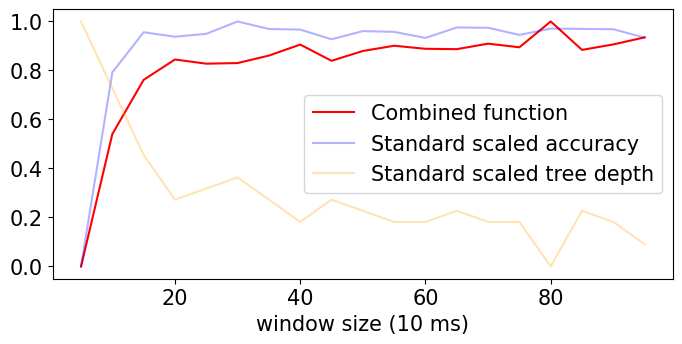

In [85]:
from scipy.optimize import minimize

# Define the combined objective function
def combined_objective(f, g, w1=0.5, w2=0.5):
    return w1 * f - w2 * g

def normalize_0_to_1(a):
    return (a-np.min(a))/(np.max(a)-np.min(a))

norm_depths = normalize_0_to_1(depths)
norm_accuracies = normalize_0_to_1(accuracies)

minimized = 0.5*norm_accuracies - 0.5*norm_depths
norm_minimized = normalize_0_to_1(minimized)

plt.rcParams.update({'font.size': 15})

fig = plt.figure(num=None,figsize=(8,3.5),dpi=100,facecolor='w',edgecolor='k')
plt.plot(steps, norm_minimized, label = "Combined function", color="red")
plt.plot(steps, norm_accuracies, label = "Standard scaled accuracy", color="blue", alpha=0.3)
plt.plot(steps, norm_depths, label = "Standard scaled tree depth", color="orange", alpha=0.3)
plt.xlabel("window size (10 ms)")
plt.legend()

optimal_window_size = steps[np.argmax(minimized)]

print("Optimal window size: ", optimal_window_size)
print("Tree depth: ", depths[np.argmax(minimized)])
print("Accuracy: ", accuracies[np.argmax(minimized)])
plt.savefig("Window_size_selection.svg", dpi=200, bbox_inches="tight")
plt.show()

In [62]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(5)

features, labels = get_features_labels(train_vibrations, noise_vibrations, optimal_window_size)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(features, labels)
selected_features = rfecv.get_support()

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {selected_features}")
print(f"Selected features: {list(features.columns)}")

Optimal number of features: 6
Selected features: [False  True  True  True  True  True False  True False False]
Selected features: ['mean', 'max', 'min', 'variance', 'std_dev', 'range', 'median', 'rms', 'kurtosis', 'skewness']


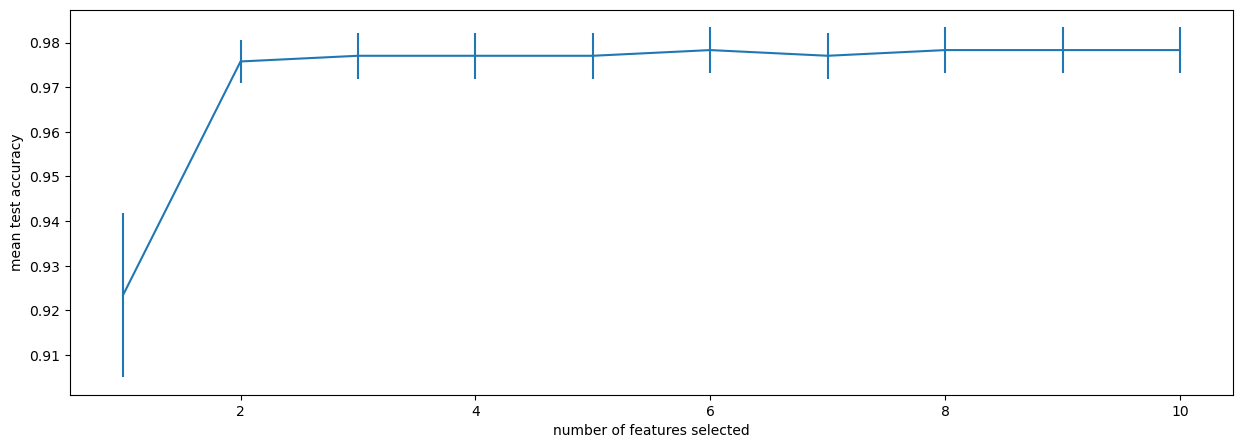

In [63]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize = (15, 5))
plt.xlabel("number of features selected")
plt.ylabel("mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
# plt.title("recursive feature Elimination \nwith correlated features")
# plt.savefig("Recursive_Feature_Elimination.png")
plt.show()

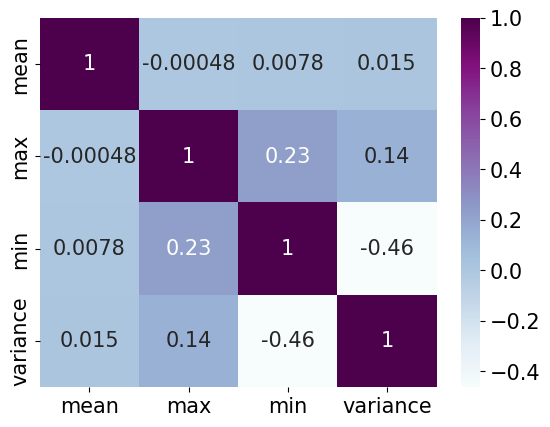

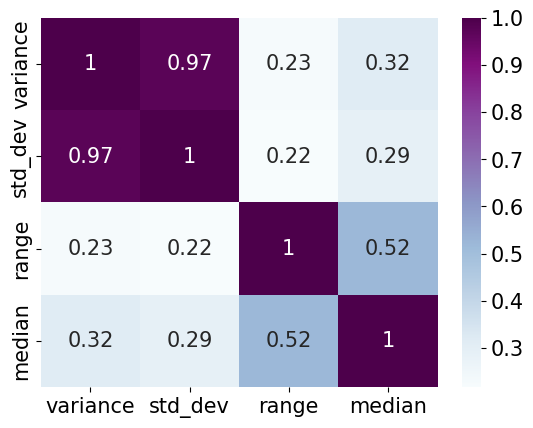

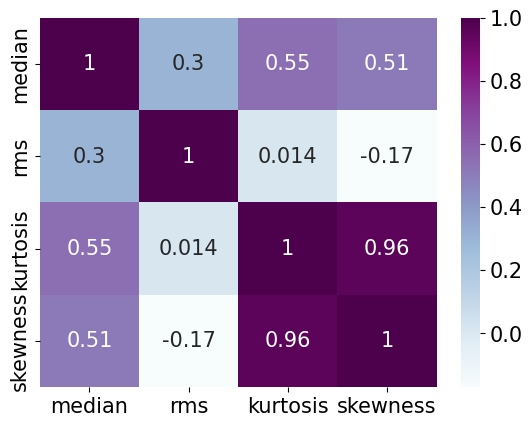

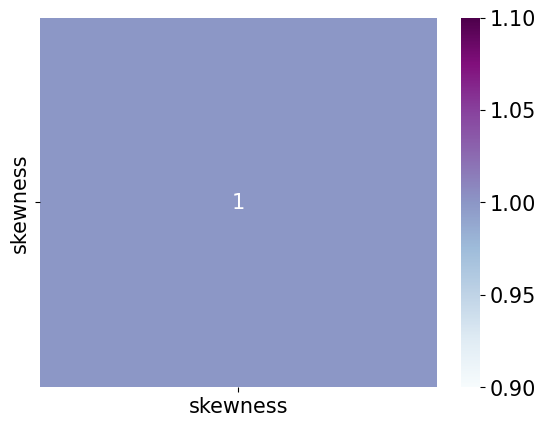

In [90]:
counter = 0
for i in range (0, features.shape[1], 3):
    counter = counter + 1
    
    cor = features.iloc[:, i:i+4].corr()
    sns.heatmap(cor, annot = True, cmap = "BuPu", annot_kws={"size": 15})
    plt.savefig("Correlation_matrix_"+ str(counter) +".svg", dpi=200, bbox_inches="tight")
    plt.show()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

In [66]:
# Initialize classifiers
classifiers = {
    "LDA": LDA(),
    "QDA": QDA(), #commented because of the error throwing
    "LogR": LogisticRegression(),
    "NBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision tree": tree.DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(tree.DecisionTreeClassifier()),
    "Random forest": RandomForestClassifier(),
    "GBT": GradientBoostingClassifier()
}

In [21]:
lda_params = {'solver': ['svd', 'lsqr', 'eigen'], 
              'shrinkage': np.arange(0, 1, 0.01)}

logr_params = {'C': np.logspace(-4, 4, 20), 
               'solver': ['liblinear', 'lbfgs'], 
               'penalty': ['l2', 'l1', 'none']}

nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

knn_params = {'n_neighbors': list(range(1, 31)), 
              'weights': ['uniform', 'distance']}

qda_params = {'reg_param': np.arange(0, 1, 0.01)}

dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
bagging_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__max_depth': [None, 10, 20],
}
rf_params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbt_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [22]:
params = {
    "LDA": lda_params,
    "QDA": qda_params ,
    "LogR": logr_params ,
    "NBayes": nb_params ,
    "KNN": knn_params,
    "Decision tree": dt_params,
    "Bagging": bagging_params,
    "Random forest":rf_params,
    "GBT": gbt_params
    
}

In [23]:
best_params_scores = []

for name, clf in classifiers.items():
    est = GridSearchCV(clf, params.get(name), cv=5)
    est.fit(X_train, y_train)
    
    best_index = est.best_index_
    best_fit_time = est.cv_results_['mean_fit_time'][best_index]
    best_score_time = est.cv_results_['mean_score_time'][best_index]
    
    best_params_scores.append({
        'Model': name,
        'Best Parameters': est.best_params_,
        'Best Score': est.best_score_,
        'Fit time': best_fit_time,
        'Test time': best_score_time
    })

    
# Convert to DataFrame for nice table format
results_df = pd.DataFrame(best_params_scores)

# Display the table
print(results_df)

           Model                                    Best Parameters  \
0            LDA               {'shrinkage': 0.0, 'solver': 'lsqr'}   
1            QDA                                 {'reg_param': 0.0}   
2           LogR  {'C': 29.763514416313132, 'penalty': 'l1', 'so...   
3         NBayes           {'var_smoothing': 4.328761281083062e-05}   
4            KNN           {'n_neighbors': 1, 'weights': 'uniform'}   
5  Decision tree  {'criterion': 'gini', 'max_depth': None, 'min_...   
6        Bagging  {'base_estimator__criterion': 'gini', 'base_es...   
7  Random forest  {'criterion': 'gini', 'max_depth': None, 'min_...   
8            GBT  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...   

   Best Score  Fit time  Test time  
0    0.995238  0.052422   0.003243  
1    1.000000  0.009609   0.001649  
2    0.998413  0.024178   0.001606  
3    0.988838  0.008047   0.000000  
4    0.971276  0.006429   0.012879  
5    0.998400  0.001600   0.006478  
6    1.000000  0.048495   0.00

In [24]:
results_df.to_excel("classifiers.xlsx", index=False)

|--- variance <= 1.99
|   |--- min <= -0.79
|   |   |--- class: 0.0
|   |--- min >  -0.79
|   |   |--- class: 1.0
|--- variance >  1.99
|   |--- class: 0.0



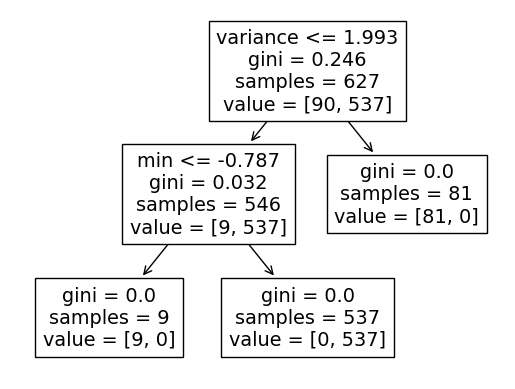

In [67]:
classifier = DecisionTreeClassifier(**results_df.loc[5,"Best Parameters"])
# classifier.set_params()
classifier.fit(X_train, y_train)

text_representation = tree.export_text(classifier, feature_names=list(features.columns))
print(text_representation)

tree.plot_tree(classifier, feature_names=list(features.columns))
# plt.savefig("Decision_tree_baseline.png", dpi=200, bbox_inches="tight")

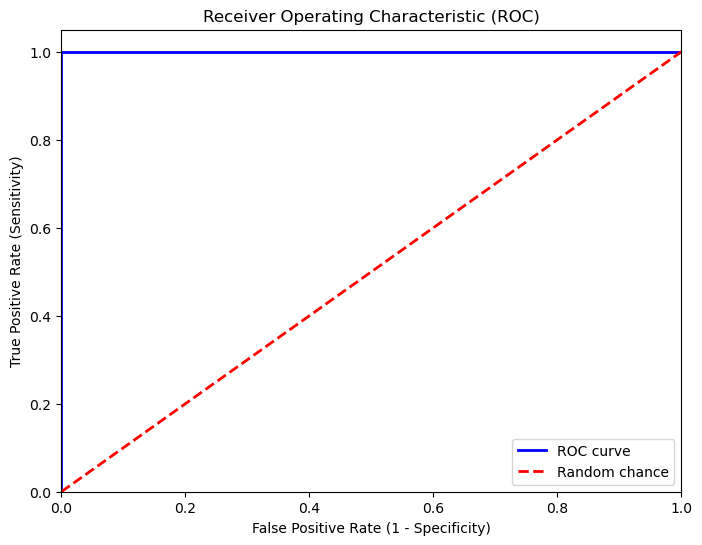

In [68]:
from sklearn.metrics import roc_curve

# Predict probabilities
# y_scores = classifier.predict_proba(X_test)[:, 1]
y_pred = classifier.predict(X_test)

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [69]:
# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 1.00
Confusion Matrix:
[[ 29   0]
 [  0 128]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157

